#  04 - Estimating Mortality Rates through Puerto Rico
### by Ian Flores Siaca
##### October 2018

## Purpose of this Notebook

#### Learning
* Getting to know the PyMC3 library
* Starting to think about Bayesian methods
* Think about uncertainty in the estimates instead of *significance vs no-significance* (*Not a fan of the p-value)

#### Project
* Estimate the mortality rate for urban areas as compared to rural areas.
* Identify which area needs more attention for future disasters.

### Bayesian methods

#### Frequentist Paradigm
Usually, this is the way statistics is done. We have the data, and estimate and test based only on this data. 
<img src="https://images.theconversation.com/files/166188/original/file-20170420-20087-u1wv5x.jpg" height="400" width="300">

[Source: The Conversation](https://theconversation.com/bayes-theorem-the-maths-tool-we-probably-use-every-day-but-what-is-it-76140)

#### Bayesian Paradigm
** But, what if we have previous knowledge, or have expert knowledge regarding a certain subject that we would like to incorporate? ** With Bayesian methods, we can set something that is called a prior, which is a distribution for each parameter of the phenomenom we want to estimate or  test. We combine this priors with the data to obtain a posterior distribution which let's us do the necessary inference.

> DISCLAIMER: Priors are controversial as some people have suggested that one can skew the results of the posterior distribution by setting the priors to certain values. This might be true in cases of few data points, however, in an open and reproducible science approach this should not be a concern as everyone alse can see your work. This is a big difference between using tools such as `R` and `Python` as compared to other click-and-touch software.

<img src="https://images.theconversation.com/files/166189/original/file-20170420-20093-1va7shd.jpg" height="400" width="300">

[Source: The Conversation](https://theconversation.com/bayes-theorem-the-maths-tool-we-probably-use-every-day-but-what-is-it-76140)

### History
* Thomas Bayes discovered it.
* Pierre-Simon Laplace greatly expanded the methods working with demographic data from France
    * Didn't know about Bayes discovery as British-French relations at the moment weren't great, even though Laplace was almost two centuries later. 
    * Invented the mathematical system for inductive reasoning in probability. 
    
### Uses

* Misile production estimation
    * Estimating the number of tanks the German Nazis were producing per factory
* Cracking the encryption
    * Breaking the Lorenz cipher using Bayesian methods
* Coast Guard Searchs
    * Searhing by quadrants for submarines in the Atlantic Ocean


### Let's code

#### Load the libraries

In [1]:
import pandas as pd
import numpy as np
import pymc3 as pm
import matplotlib.pyplot as plt

/home/kropotkin/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


#### Load the data

In [3]:
census_data = pd.read_csv("../data/census.csv")
census_data = census_data.drop(['Unnamed: 0'], axis = 1)

In [4]:
mortality_data = pd.read_csv("../data/mortality_grouped.csv")
mortality_data = mortality_data.drop(['Unnamed: 0'], axis = 1)

#### Calculating mortality rates
* We first join the census data to the mortality DataFrame. This order matters as the mortality DataFrame has more information than the census data. 
* We then divide the number of deaths by the number of people in each municipality and the multiply by 1000 to get the mortality rate per 1000 people. 

In [5]:
df = mortality_data.merge(census_data, on='ResidencePlace')
df['death_rate'] = (df['Deaths']/df['respop72017']) * 1000
df.head()

,ResidencePlace,ResidenceZone,Deaths,respop72017,death_rate
0,ADJUNTAS,RURAL,63,17971,3.505648
1,ADJUNTAS,URBANO,50,17971,2.782260
2,AGUADA,RURAL,165,38118,4.328664
3,AGUADA,URBANO,37,38118,0.970670
4,AGUADILLA,RURAL,320,53164,6.019111


Here we are making two DataFrames, one with the information for the rural zones and one for the urban zones.

In [6]:
rural = df[df['ResidenceZone'] == 'RURAL']['death_rate']
urban = df[df['ResidenceZone'] == 'URBANO']['death_rate']

`PyMC3`, the package we are using for Bayesian estimation, requires the data in a certain structure, which is what we are doing in this code cell below. 

In [14]:
total = pd.DataFrame(dict(death_rate = np.r_[rural, urban],
                         group = np.r_[['rural']* len(rural), 
                                      ['urban'] * len(urban)]))
total.head()

,death_rate,group
0,3.505648,rural
1,4.328664,rural
2,6.019111,rural
3,5.299807,rural
4,4.111130,rural


#### Priors

As mentioned before, when doing bayesian estimation we need to set our priors. In this case I'm stating that my prior for the mean mortality rate in each zone should be close to the total death rate. In this case, I am modeling this priors with a TruncatedNormal distribution from the `PyMC3` library. 

In [8]:
mu_total = total.death_rate.mean()
std_total = total.death_rate.std()

In [9]:
with pm.Model() as model:
    rural_mean = pm.TruncatedNormal('rural_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)
    urban_mean = pm.TruncatedNormal('urban_mean', 
                                    mu = mu_total, 
                                    sd = std_total, 
                                    lower = 0, upper = 1000)

In [10]:
std_low = 0
std_high = 10

with model:
    rural_std = pm.Uniform('rural_std', lower = std_low,
                          upper = std_high)
    urban_std = pm.Uniform('urban_std', lower = std_low, 
                          upper = std_high)

In [11]:
with model:
    v = pm.Gamma('v', alpha = 3, beta = 1)

#### Likelihood

In [12]:
with model:
    lambda_rural = rural_std**-2
    lambda_urban = urban_std**-2
    
    rural_try = pm.StudentT('rural', nu = v, mu = rural_mean, 
                            lam = lambda_rural, observed = rural)
    urban_try = pm.StudentT('urban', nu = v, mu = urban_mean, 
                           lam = lambda_urban, observed = urban)

In [13]:
with model:
    diff_of_means = pm.Deterministic('difference of means', 
                                     rural_mean - urban_mean)
    
    diff_of_stds = pm.Deterministic('difference of stds', 
                                    rural_std - urban_std)
    
    effect_size = pm.Deterministic('effect size',
                                  diff_of_means / np.sqrt((rural_std**2 + urban_std**2) / 2))

#### Sampling

In [15]:
with model:
    trace = pm.sample(20000, cores = 2, tune = 15000)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [v, urban_std, rural_std, urban_mean, rural_mean]
Sampling 2 chains: 100%|██████████| 70000/70000 [00:55<00:00, 1271.54draws/s]


In [15]:
pm.plot_posterior(trace, varnames = ['urban_mean'], color = '#0d98ba')

NameError: name 'trace' is not defined

In [16]:
pm.plot_posterior(trace, varnames = ['urban_std'], color = '#0d98ba')

NameError: name 'trace' is not defined

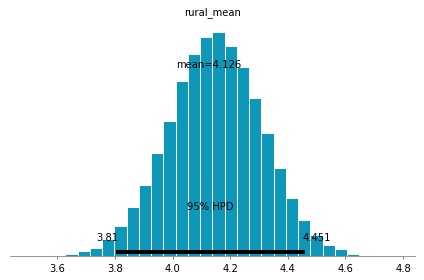

In [115]:
pm.plot_posterior(trace, varnames = ['rural_mean'], color = '#0d98ba')

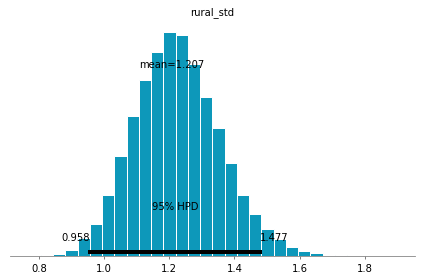

In [124]:
pm.plot_posterior(trace, varnames = ['rural_std'], color = '#0d98ba')

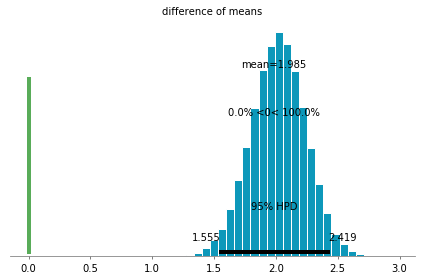

In [128]:
pm.plot_posterior(trace, varnames = ['difference of means'], color = '#0d98ba', ref_val=0)

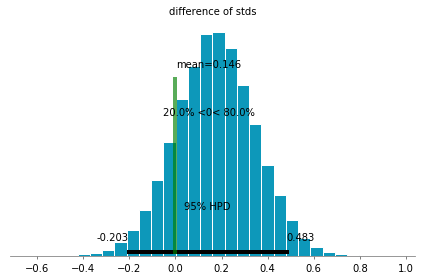

In [17]:
pm.plot_posterior(trace, varnames = ['difference of stds'], color = '#0d98ba', ref_val=0)

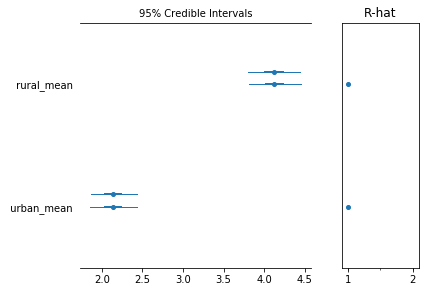

In [129]:
pm.forestplot(trace, varnames = ['rural_mean', 'urban_mean'])